In [2]:
# To run this notebook in Google Colab, uncomment the following line to
# install all required packages.
#!pip install git+https://github.com/simonpf/at652

# Machine learning for remote sensing


![Machine learning for precipitation retrievals](../figures/retrieval.png)



## Motivation

- Remote sensing provides a wealth of observations, however, they are typically only indirectly related to physical quantities of interest, i.e., temperature profiles, surface precipitation, etc.

![Machine learning for precipitation retrievals](../figures/retrieval.png)

### Why machine learning?

- Many remote-sensing applications are data rich
- The relationships between observations and variables of interest are often complex (non-linear, non-unique) making it difficult to come up with explicit programs to estimate the target variables from observations

### Why now?

- Many of the neural network (NN) architectures still used today have been around since the 90s
- However, deep learning, which is essentially drive by NNs, has only gained momentum since about 2012
- Principal advances in ML are driven by compute: more complex models, larger datasets

### Why now? (cnt'd)

- Transistor size (which is inversely related to compute power) has been decreasing exponentially since the 1970s
![Moore's law](https://assets.ourworldindata.org/uploads/2020/11/Transistor-Count-over-time.png)

## Machine learning basics

### Aim

- Machine learning aims to infer algorithmic behavior from data 

![From programming to machine learning](../figures/programming_vs_machine_learning.png)

### Terminology

![Taxonomy of machine learning](../figures/ml_terminology.png)

### Conventions

![Data organization](../figures/conventions.svg)

### Basic workflow

1. Collect data
2. Perform exploratory data analysis (EDA).
3. Split data into training, validation, and test sets. **Do not use test data before step 6**.
4. Use training and validation data to train and evaluate your model
5. Optional: Improve model, collect more data, fix issues, train for longer
6. Evaluate model accuracy on test set

> **Note**: Think of the test set as being single-use. If you choose a model based on test-set performance, you leaked information from the test set into your model. This *may* not be critical with sufficiently large datasets but is generally frowned upon.

### Mathematical formulation

![Mathematical formulation](../figures/ml_ingredients.svg)

where:
   - <span style="color: #ff9900ff;">$f(\theta, x)$</span> is a model parametrized by a potentially large number of parameters $\mathbf{\theta} = [\theta_1, \ldots, \theta_n]$
   - <span style="color: #99cc33ff;">$\mathcal{L}(y, \hat{y})$</span> is a loss function or learning criterion that quantifies the error given a reference value $y$ and a model prediction $\hat{y} = f(\theta, x)$. The total loss is typically calculated as the mean over training data.
   - <span style="color: #6699ffff;">$\text{argmin}_\mathbf{\theta}$</span> denotes the operation of finding parameters $\mathbf{\theta}$ that minimize the loss function


> **Note:** Three ingredients! How hard could it be? ¯\_(ツ)_/

## A simple example

- Assume we want to learn a mapping from the input data to the output data below

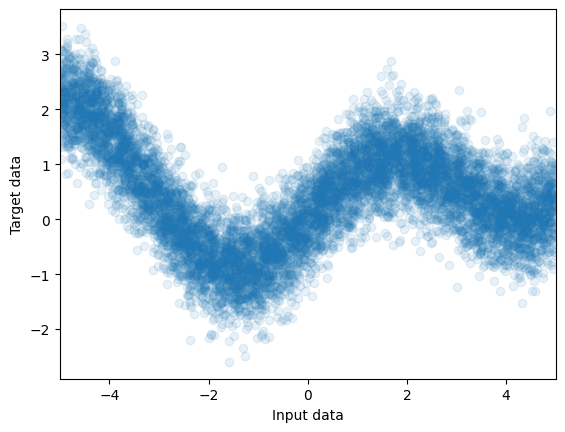

In [3]:
import numpy as np
import matplotlib.pyplot as plt

n_samples = 10_000
input_data = np.random.uniform(-5, 5, size=n_samples)
target_data = 0.05 * input_data ** 2 + np.sin(input_data) + 0.5 * np.random.normal(size=input_data.size)

f, ax = plt.subplots(1, 1)
ax.scatter(input_data, target_data, alpha=0.1)
ax.set_xlim(-5, 5)
ax.set_xlabel("Input data")
ax.set_ylabel("Target data");

### Linear regression

![Linear regression](../figures/ml_ingredients.svg)

#### Formulation

- Model: $f(\theta, x) = \theta_1 x + \theta_2$



- Loss function: $\mathcal{L}(y, \hat{y}) = (y - \hat{y})^2$

- Optimizer:
    - Optimization criterion is convex, which guarantees a unique minimum
    - Only need to find $\theta$ such that $\nabla \sum_i^N \mathcal{L}(y_i, f(\theta, x_i) = 0$

#### Explicit solution

- Let's write the input data as a matrix: $ X = \begin{pmatrix} x_1 & 1 \\ \vdots & \vdots \\ x_N & 1 \end{pmatrix}$
- We can then write the mean of the loss function over the training dataset as
$$
L(\theta) = \frac{1}{N} \sum_i^N \mathcal{L}(y_i, f(\theta, x-i)) = \frac{1}{N}(Y - X \theta)^T (Y - X \theta)
$$
where:
   -  $\theta  = \begin{pmatrix} \theta_1 \\ \theta_2 \end{pmatrix}$
   -  $ Y= \begin{pmatrix} y_1 \\ \vdots \\ y_N \end{pmatrix}$

- $\nabla L(\theta) = -\frac{2}{N} X^T(Y - X\theta)$
> The optimal $\theta$ is thus given by the solution of the linear system of queation given by $X^Ty = X^TX\theta$

#### Explicit solution in Python

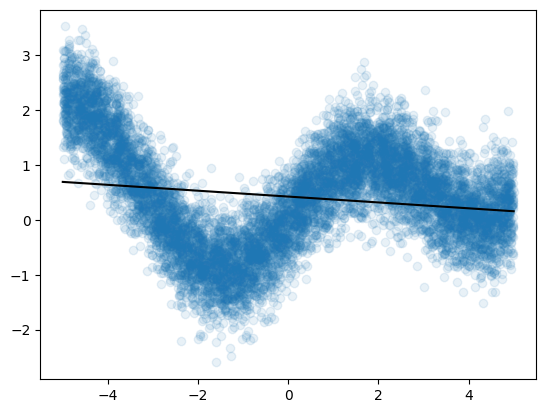

In [4]:
x = input_data
y = target_data
x_and_1 = np.stack([x, np.ones_like(x)], -1)
xt_x = x_and_1.T @ x_and_1
y_x = x_and_1.T @ y

theta = np.linalg.solve(xt_x, y_x)

f, ax = plt.subplots(1, 1)
ax.scatter(input_data, target_data, alpha=0.1)
x_new = np.linspace(-5, 5, 11)
ax.plot(x_new, theta[0] * x_new + theta[1], c="k")

#### The loss landscape

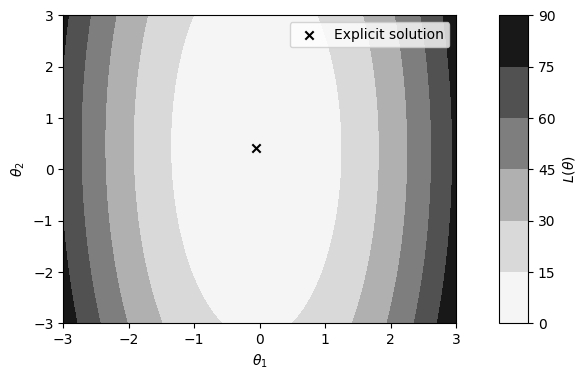

In [6]:
import at652
from at652.chapter_1 import plot_loss_landscape

theta_1 = np.linspace(-3, 3, 101) # Shape [101]
theta_2 = np.linspace(-3, 3, 101) # Shape [101]
theta_grid = np.stack(np.meshgrid(theta_1, theta_2)) # Shape [2, 101, 101]
# Flatten last dimension to obtain matrix of shape [2, 101 x 101]
losses =  np.mean((y[..., None] - x_and_1 @ theta_grid.reshape(2, -1)) ** 2, axis=0)
# Bring back loss into grid shape [101 x 101]
loss_grid = losses.reshape(theta_grid.shape[1:])

_ = plot_loss_landscape(theta_grid, loss_grid, theta_true=theta)

#### Summary: Linear regression

![Linear regression](../figures/ml_ingredients_linear_regression.svg)

- **Disadvantages**:
  - Explicit solution of the optimization only possible for *very* simple models
  - Naive implementation requires all data to be loaded into memory thus limiting datasets to a couple of hundreds of GB

## From linear regression to neural networks

### Roadmap

1. Devise a more generic optimization scheme to handle more complex families of models.
1. Build a more complex model: stack multiple affine transformations, i.e. linear regression layers, with non-linear activation functions.

### Gradient descent (GD) optimization

1. Start with a best guess $\theta_0$ for the optimal value
2. Calculate the gradient $\frac{\delta \mathcal{L(y, f(\theta, y)}}{\delta \theta}$.
3. Calculate a new candidate for the optimal value by moving in the *opposite* direction of the gradient: $x_{i + 1} = x_i - l \cdot \frac{\delta \mathcal{L(y, f(\theta, y)}}{\delta \theta} $.
  where step length $l$ is typically a small value $l < 0.01$
5. Repeat steps 2. - 3. until convergence

> **Note**: In machine-learning the step length $l$ is typically called learning rate.
   

### Application to linear regression

In [7]:
def dl_dtheta(theta: np.ndarray, x_and_1: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Calculate the gradient of the MSE for the linear regression problem 
    defined by the matrix x_and_1 and y.

    Args:
        theta: A 2-element vector containing the linear regression parameters.
        x_and_1: The matrix obtained by stacking the vector of input values x and vector
            with all ones along the column-dimension.
        y: A vectory y containing the target values.

    Return:
        dl_dx: A 2-element vector containing the gradient of the linear-regression loss function.
    """
    return - 2 / x_and_1.shape[0] * x_and_1.T @ (y - x_and_1 @ theta)


In [28]:
from typing import Callable, List, Tuple

def gradient_descent(
    dl_dtheta: Callable[[np.ndarray], np.ndarray],
    n_steps: int
) -> Tuple[np.ndarray, List[np.ndarray]]:
    """
    Optimize the objective function L(theta) using gradient descent.

    Args:
        dl_dtheta: A callable providing the gradient of the objective function
             for a given value of theta.
        n_steps: The number of steps to perform

    Return:
        A tuple ``(theta, steps)`` containing the final theta vector and a
        list of all previous optimization steps.
    """
    # Start with random parameter vector
    theta_i = np.random.normal(size=2)
    steps = []
    for _ in range(n_steps):
        steps.append(theta_i)
        theta_i = theta_i - 0.01 * dl_dtheta(theta_i, x_and_1, y)
    return theta_i, steps

### Linear regression using GD

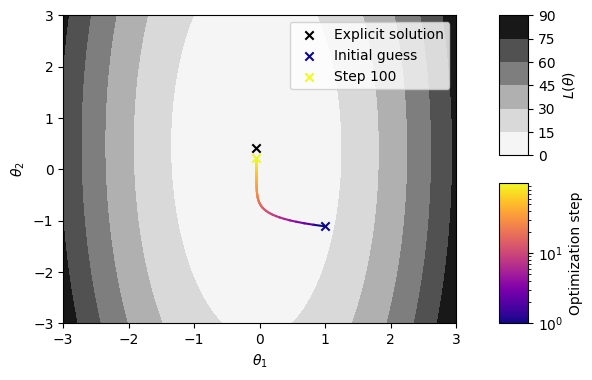

In [30]:
from at652.chapter_1 import plot_optimization_steps

theta_opt, steps_gd = gradient_descent(dl_dtheta, 100)
fig, ax, cax = plot_loss_landscape(theta_grid, loss_grid, theta_true=theta, split_cb=True)
plot_optimization_steps(ax, steps_gd, cax=cax, label_end_points=True)

### Stochastic gradient descent (SGD)

 - Disadvantage of GD: requires iteration over all training data to calculate a single optimization step
 - How it works:
     - Instead of calculating $L(\theta) = \frac{1}{N} \sum_i ^N \mathcal{L}(\hat{y_i}, f(\theta, x_i)$ over all samples in the training data use a different, randomly-chosen, subset of the training data:
  $$
  L(\theta) \approx \frac{1}{N_B} \sum_{i \in B} \mathcal{L}(\hat{y_i}, f(\theta, x_i))
$$


### Python implementation

In [31]:
from typing import Callable, List, Tuple

def stochastic_gradient_descent(
    dl_dtheta: Callable[[np.ndarray], np.ndarray],
    n_steps: int,
    batch_size: 1
) -> Tuple[np.ndarray, List[np.ndarray]]:
    """
    Optimize the objective function L(theta) using gradient descent.

    Args:
        dl_dtheta: A callable providing the gradient of the objective function
             for a given value of theta.
        n_steps: The number of steps to perform

    Return:
        A tuple ``(theta, steps)`` containing the final theta vector and a
        list of all previous optimization steps.
    """
    # Start with random parameter vector
    theta_i = np.random.normal(size=2)
    steps = [theta_i]
    for _ in range(n_steps):
        batch_indices = np.random.choice(x_and_1.shape[0], size=batch_size)
        theta_i = theta_i - 0.01 * dl_dtheta(theta_i, x_and_1[batch_indices], y[batch_indices])
        steps.append(theta_i)
    return theta_i, steps

### Linear regression using SGD

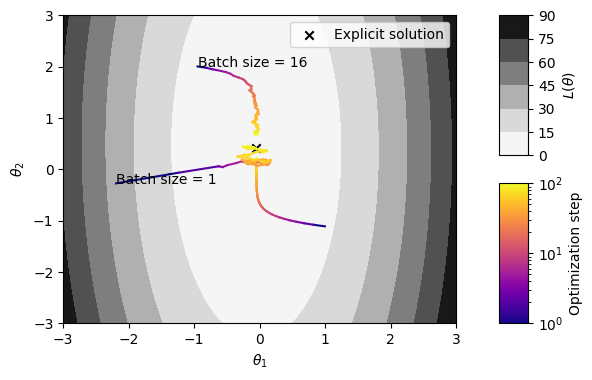

In [32]:
from at652.chapter_1 import plot_optimization_steps

theta_opt, steps_sgd_1 = stochastic_gradient_descent(dl_dtheta, 100, 1)
theta_opt, steps_sgd_16 = stochastic_gradient_descent(dl_dtheta, 100, 16)
fig, ax, cax = plot_loss_landscape(theta_grid, loss_grid, theta_true=theta, split_cb=True)
plot_optimization_steps(ax, steps_gd, cax=cax, label_end_points=False)
plot_optimization_steps(ax, steps_sgd_1, cax=cax, label_end_points=False, label="Batch size = 1")
plot_optimization_steps(ax, steps_sgd_16, cax=cax, label_end_points=False, label="Batch size = 16")

### Neural networks

- Neural network are typically constructed by stacking multiple layers of relatively simple, learnable transformations
- The most basic neural-network is the fully-connected, or feed-forward neural network, which stack affine transformations (think linear regression) and non-linear, element-wise activation functions.

![A fully-connected neural network](../figures/neural_network.svg)

> Problem: But how do we compute the gradients of neural networks?

### The chain rule is all you need

  - SGD optimization requires calculating the gradients of the loss function
  - Consider the four-layer network above. The output $\hat{y}$ is given by:
    $$
    \hat{y}  = f_4(f_3(f_2(f_1(x)))
    $$
    where
    $$
    f_i(x) = \text{act}_i(W_ix + b_i)
    $$
   

 
  - The gradients of the weight matrices $W_i, i = 1, \ldots, 4$ are given by
    $$
    \frac{dL}{dW_4} = \frac{dL}{dx}
    $$
    $$
    \frac{dL}{dW_3} = \frac{dL}{dx} \frac{df_4}{dx} \frac{d \text{act}_3}{dx}
    $$
    $$
    \frac{dL}{dW_2} = \frac{dL}{dx} \frac{df_4}{dx} \frac{df_3}{dx} \frac{d \text{act}_2}{dx}
    $$
    $$
    \frac{dL}{dW_1} = \frac{dL}{dx} \frac{df_4}{dx} \frac{df_3}{dx} \frac{df_2}{dx} \frac{d \text{act}_1}{dx}
    $$

 - Using the chain rule, we can calculate the gradients for all parameters of the NN by *stepping backwards through the network*. This method is called **backpropagation**.

>  **Note:** I have been slightly abusing the notation here. Typically, $x$ and $y$ are multi-dimensional object, i.e., matrices or tensors, and most product become tensor products. Implementing this in code thus requires a bit more thinking but luckily we don't have to deal with this :).

## PyTorch to the rescue

 - We could implement backpropagation in Python to calculate the gradients of the loss term for arbitrarily deep neural networks. However, this is, of course, way to cumbersome for busy scientists 🧑‍🔬.
 - Luckily there are software frameworks that can do this for us. **PyTorch** is one of them.

In [9]:
import torch
from torch import nn

# We create a parameter vector for our two linear regression parameters.
# This tells PyTorch that we want to keep track of the gradients w.r.t. these two variables.
theta = nn.Parameter(torch.normal(torch.zeros(2), torch.ones(2)))
x_and_1 = torch.tensor(x_and_1).to(torch.float32)
y = torch.tensor(target_data).to(torch.float32)

# Let's calculate our loss
loss = ((y - x_and_1 @ theta) ** 2).mean()
# The backward function calculates the gradients of the loss w.r.t. to our two parameters.
loss.backward()

print(f"dL/dx = {theta.grad}")

dL/dx = tensor([-6.1621, -1.3625])


### A first neural network in PyTorch

In [10]:
from torch import nn

# All PyTorch models should inherit from nn.Module. This exposes
# a range of functionality useful for keeping track of learnable parameters.
class FullyConnected(nn.Module):
    """
    A simple fully-connected neural network implemented using PyTorch.
    """
    def __init__(self, n_neurons: int):
        """
        Args:
            n_neurons: The number of neurons in the hidden layers of the network.
        """
        super().__init__()
        self.w_1 = nn.Parameter(torch.zeros((1, n_neurons)))
        self.b_1 = nn.Parameter(torch.zeros((1, n_neurons)))
        self.w_2 = nn.Parameter(torch.zeros((n_neurons, n_neurons)))
        self.b_2 = nn.Parameter(torch.zeros((1, n_neurons)))
        self.w_3 = nn.Parameter(torch.zeros((n_neurons, n_neurons)))
        self.b_3 = nn.Parameter(torch.zeros((1, n_neurons)))
        self.w_4 = nn.Parameter(torch.zeros(n_neurons, 1))
        self.b_4 = nn.Parameter(torch.zeros((1)))

        # For example, we can use the parameters of nn.Module  method to iterate
        # over the parameters in the model.
        for param in self.parameters():
            nn.init.uniform_(param, a=-0.1, b=0.1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Propagate input throught the neural network.

        Args:
            x: 

        Return:
           A tensor containing the NN output y

        """
        z_1 = nn.functional.relu(x @ self.w_1 + self.b_1)
        z_2 = nn.functional.relu(z_1 @ self.w_2 + self.b_2)
        z_3 = nn.functional.relu(z_2 @ self.w_3 + self.b_3)
        y = z_3 @ self.w_4 + self.b_4
        return y

### The training (optimization) loop

In [11]:
simple_nn = FullyConnected(128)

l = 1e-2
batch_size = 32
x = torch.tensor(input_data).reshape(-1, 1).to(torch.float32)
y = torch.tensor(target_data).reshape(-1, 1).to(torch.float32)

for step in range(1_000):
    # Generate random batch indices for SGD
    batch_indices = torch.tensor(np.random.choice(x.shape[0], size=batch_size))
    # Propagate batch through network.
    y_hat = simple_nn(x[batch_indices])
    # Calculate MSE
    mse = ((y[batch_indices] - y_hat) ** 2).mean()
    # Calculate gradients
    mse.backward()
    # Perform SGD step on all parameters.
    for param in simple_nn.parameters():
        param.data -= l * param.grad
    # Zero out gradients. This is necessary because PyTorch accumulates
    # gradients between subsequent .backward() calls.
    simple_nn.zero_grad()


### Results

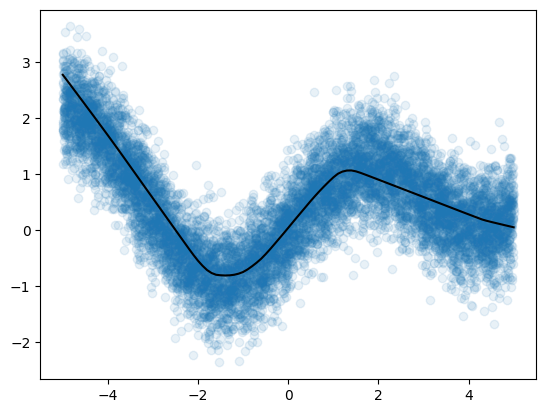

In [12]:
x = torch.linspace(-5, 5, 101).reshape(-1, 1)
# For inference, i.e., evaluating the model, we turn off gradient
# tracking using the torch.no_grad() context manager. 
# This is faster and requires less memory.
with torch.no_grad():
    y_pred = simple_nn(x)
    
plt.scatter(input_data, target_data, alpha=0.1, label="Neural network")
plt.plot(x, y_pred, c="k")

## It doesn't have to be this messy

- PyTorch provides a range of functionality to abstract much of the boiler-plate code of the above implementation

### Data handling

- Data is typically loaded using a dataset that is wrapped into a data loader
- The dataset object typically implements the loading of a single training sample
   - This is what you typically need to implement
- The data loader then combines single samples into batches. It also allows for easy parallelization of the data loading across multiple CPU processes

In [13]:
from torch.utils.data import TensorDataset, DataLoader

# Since we work with a relatively small dataset and already loaded it to memory,
# we use PyTorch's TensorDataset class to wrap the data.
x = torch.tensor(input_data).to(dtype=torch.float32).reshape(-1, 1)
y = torch.tensor(target_data).to(dtype=torch.float32).reshape(-1, 1)
dataset = TensorDataset(x, y)

# The data loader then allows us to iterate over the batches in the dataset.
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

for x, y in data_loader:
    print(f"x.shape={x.shape}, y.shape={y.shape}")
    break

x.shape=torch.Size([16, 1]), y.shape=torch.Size([16, 1])


### PyTorch modules

 - PyTorch provides a range of neural network components, called modules, that simplify the building of more complex models.

In [14]:
simple_nn = nn.Sequential(
    nn.Linear(1, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

### Training loop

- PyTorch also provides a wide range of optimizer classes that take care of the optimization step

In [15]:
from torch.optim import SGD
optimizer = SGD(simple_nn.parameters())

n_epochs = 100
loss_fn = nn.MSELoss()

for epoch_index in range(n_epochs):

    epoch_loss = 0.0
    
    for x_b, y_b in data_loader:
        
        loss = loss_fn(y_b, simple_nn(x_b))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # The item() function extract the floating point value of the loss and
        # avoid PyTorch from further tracking gradients.
        epoch_loss += loss.item()

    if epoch_index % 10 == 1:
        print(f"Epoch {epoch_index}, loss: {epoch_loss / len(data_loader)}")

Epoch 1, loss: 0.5257411334633827
Epoch 11, loss: 0.25678016911149026
Epoch 21, loss: 0.25467968673706054
Epoch 31, loss: 0.25458973311185834
Epoch 41, loss: 0.2532173806071281
Epoch 51, loss: 0.2530683039546013
Epoch 61, loss: 0.2522497585177422
Epoch 71, loss: 0.2524183247208595
Epoch 81, loss: 0.2513626052737236
Epoch 91, loss: 0.2511516662478447


## Recap

1. The three main ingredients of modern ML:
![The three main ingredients of modern ML](../figures/ml_ingredients_recap.svg)
  - ➡️ Those are the basics. However, there are a few more tricks required to make the NN work really well.

2. How to implement them using PyTorch:
![The three main ingredients of modern ML](../figures/ml_ingredients_pytorch.svg)

3. Using PyTorch functionality to make implementing NNs less tedious
    - ➡️ More of this next lecture